# Classification metrics overview

A really good guide when choosing the right metric for a problem by the awesome Koo Ping Shung [7] :

> __First Question:__ Does both True Positive and True Negatives matters to the business or just True Positives? If both is important, Accuracy is what you go for.
>
> __Second Question:__ After establishing that True Positive is what you are concerned with more, ask yourself, which one has a higher costs to business, False Positives or False Negatives?
>
> If having large number of False Negatives has a higher cost to business, choose Recall.
>
> If having large number of False Positives has a higher cost to business, choose Precision.
>
> If you cannot decide or thinks that its best to reduce both, False Negatives and False Positives then choose F1.
Hope the above two questions will simplify which metrics to choose.

<br>

Refs.:

[1] https://stackoverflow.com/a/54458777/4885494

[2] https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226 (superb caveats definition)

[3] https://www.kdnuggets.com/2018/06/right-metric-evaluating-machine-learning-models-2.html 

[4] https://developers.google.com/machine-learning/crash-course/classification/thresholding (cases and some really good insights)

[5] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

[6] https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

[7] https://koopingshung.com/blog/machine-learning-model-selection-accuracy-precision-recall-f1/

[8] https://medium.com/@shmueli/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2

[9] https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

[10] https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5 (thanks god, this is THE auc tutorial <3)

[11] https://towardsdatascience.com/the-ultimate-guide-to-binary-classification-metrics-c25c3627dd0a#a1d0

[12] https://towardsdatascience.com/evaluating-categorical-models-ii-sensitivity-and-specificity-e181e573cff8

[13] http://gim.unmc.edu/dxtests/reviewof.htm

#### Imports

In [265]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Input

#### Sample models

For this guide, we will be using two different classification models :
- Binary classification (two classes)
- Multiclass classification single-label (multiple classes)

In [66]:
# Binary model
breast_dataset = load_breast_cancer()
X_breast = breast_dataset['data']
y_breast = breast_dataset['target']
x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(X_breast, y_breast, test_size=0.3, random_state=42)

binary_model = Sequential()
binary_model.add(Dense(16, input_dim=30, activation='relu'))
binary_model.add(Dense(8, activation='relu'))
binary_model.add(Dense(1, activation='sigmoid'))
binary_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
binary_model.fit(x_b_train, y_b_train, epochs=50, validation_data=(x_b_test, y_b_test), verbose=0)
binary_preds = binary_model.predict(x_b_test)
binary_preds = [1 if pred>0.5 else 0 for pred in binary_preds]

# Multi class single-label model
iris_dataset = load_iris()
X_iris = iris_dataset['data']
y_iris = to_categorical(iris_dataset['target'])
x_i_train, x_i_test, y_i_train, y_i_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

multi_class_model = Sequential()
multi_class_model.add(Dense(10, input_dim=4, activation='relu'))
multi_class_model.add(Dense(10, activation='relu'))
multi_class_model.add(Dense(3, activation='softmax'))
multi_class_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
multi_class_model.fit(x_i_train, y_i_train, batch_size=5, epochs=200, validation_data=(x_i_test, y_i_test), verbose=0)
multiclass_preds = to_categorical(multi_class_model.predict_classes(x_i_test))

## Confusion matrix

<br>

The confusion matrix is a representation of the relation between actual classes and predicted classes.

Its rows represent the actual classes while the columns represet the predicted classes.

<br>

Basically, the confusion matrix is composed by (for binary classification):
- True positives (TP) - when a positive class is correctly classified as a positive class.
- True negatives (TN) - when a negative class is correclty classified as a negative class.
- False positives (FP) - when a negative class is wrongly classified as a positive class.
- False negatives (FN) - when a positive class is wrongly classified as a negative class.

<br>

For the case of multiclass classification problems, the same structure is applied, with the difference that now the shape of the confusion matrix will be NxN, given N possible classes on the network output.

In [193]:
# Binary classific
cm = confusion_matrix(y_b_test, binary_preds)
data = {'Negative': cm[:,0], 'Positive': cm[:,1]}
df = pd.concat({"Predicted": pd.DataFrame(data, index=[['True Label', 'True Label'],['Negative', 'Positive']])}, axis=1)
df

Predicted         
                     Negative Positive
True Label Negative        59        4
           Positive         6      102

In [110]:
# Multiclass classification confusion matrix
cm2 = confusion_matrix(y_i_test.argmax(axis=1), multiclass_preds.argmax(axis=1))
pd.DataFrame(data=cm2, columns=range(3), index=range(3))

,0,1,2
0,10,0,0
1,0,8,1
2,0,0,11


Some observations for the confusion matrix from the multiclass classifier :
- the diagonal of the confusion matrix are the true positive (TP) cases, [10, 8, 11]
- the value from the position [1,2] (row 1 / column 2) tells us how many samples from class 1 were identified as class 2

<br>

Usually, the confusion matrix is represented by : columns (true label) and rows (predicted labels).

In the case of the confusion matrix generated by sklearn, this matrix is kind of "transposed", with the columns representing the predicted classes and the rows representing the true labels.

## Accuracy

__*accuracy = (tp + tn) / (tp + fp + tn + fn)*__

Accuracy is the metrics that measures how many observations were correctly classified.

This is basically the ratio between the true positives and all the other predictions (tp, fp, tn and fn).

<br>

__when to use__:
- it is good to use when there is no class imbalance and no skeweness
- can be used for both binary and multiclass classification problems

__caveats__:
- as the target distribution is very sparse, it can lead to incorrect conclusions : e.g., if we are trying to predict if an extremelly rare event will happen or not, let's say it happens 1/100 times. If our classifier only outputs 100 "false" labels, our accuravy will by 99% even if our real interest, the "true" label was misclassified.

__cases__:
- In the game of roulette, a ball is dropped on a spinning wheel and eventually lands in one of 38 slots. Using visual features (the spin of the ball, the position of the wheel when the ball was dropped, the height of the ball over the wheel), an ML model can predict the slot that the ball will land in with an accuracy of 4%.
    - This ML model is making predictions far better than chance; a random guess would be correct 1/38 of the time—yielding an accuracy of 2.6%. Although the model's accuracy is "only" 4%, the benefits of success far outweigh the disadvantages of failure.
- A deadly, but curable, medical condition afflicts .01% of the population. An ML model uses symptoms as features and predicts this affliction with an accuracy of 99.99%.
    - Accuracy is a poor metric here. After all, even a "dumb" model that always predicts "not sick" would still be 99.99% accurate. Mistakenly predicting "not sick" for a person who actually is sick could be deadly.
- An expensive robotic chicken crosses a very busy road a thousand times per day. An ML model evaluates traffic patterns and predicts when this chicken can safely cross the street with an accuracy of 99.99%.
    - A 99.99% accuracy value on a very busy road strongly suggests that the ML model is far better than chance. In some settings, however, the cost of making even a small number of mistakes is still too high. 99.99% accuracy means that the expensive chicken will need to be replaced, on average, every 10 days. (The chicken might also cause extensive damage to cars that it hits.)

In [164]:
print(f"Binary model accuracy : {accuracy_score(y_b_test, binary_preds)}")
print(f"Multiclass single-label model accuracy : {accuracy_score(y_i_test, multiclass_preds)}")

Binary model accuracy : 0.9415204678362573
Multiclass single-label model accuracy : 0.9666666666666667


## Precision (Positive predictive value)

__*precision = tp / (tp+fp)*__

The precision metric can be thought as the accuracy of the positive predictions.

It is the ratio of the true positive predictions against all positive predictions, both correct and wrong ones.

The precision metrics answers the following question : "From all the positive predictions, how many of them were trully positive?"

<br>

__when to use__:
- when we want to be sure of our predictions (true predictions in the case of binary classifier)
- Precision is a good measure to determine, when the costs of False Positive is high. For instance, email spam detection. In email spam detection, a false positive means that an email that is non-spam (actual negative) has been identified as spam (predicted spam). The email user might lose important emails if the precision is not high for the spam detection model.

__caveats__:
- Following the binary classifier example, as we are focusing on making sure that we get only the emails that trully are spams and not deleting ham emails wrongly, we end up letting some spams pass through our filter as we do not focus on the false nagtives nor true negative cases.

__cases__:
- Consider a classification model that separates email into two categories: "spam" or "not spam." If you raise the classification threshold, what will happen to precision?
    - Probably increase, in general, raising the classification threshold reduces false positives, thus raising precision.

In [215]:
print(f"Binary model precision : {precision_score(y_b_test, binary_preds)}")

Binary model precision : 0.9622641509433962


For multiclass/multilabel cases, we also need to set an extra parameter that specifies which __average__ approach will be taken.

- __*micro*__ : calculate metrics globally by counting the total true positives, false negatives and false positives.
- __*macro*__ : calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
- __*weighted*__ : Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
- __*samples*__ : Calculate metrics for each instance, and find their average

In [244]:
averages = ['micro', 'macro', 'weighted', 'samples']
print(f"Multiclass single-label precision methods\n")
for avg in averages:
    print(f"{avg} average : {precision_score(y_i_test, multiclass_preds, average=avg)}")

Multiclass single-label precision methods

micro average : 0.9666666666666667
macro average : 0.9722222222222222
weighted average : 0.9694444444444444
samples average : 0.9666666666666667


## Recall / Sensitivity (True positive rate)

__*recall = tp / (tp+fn)*__

The recall metrics answers the following questions : 

"What proportion of actual positives was identified correctly?"

"How many positive cases wrongly passed by as negatives?"

<br>

__when to use__:
- recall metric should be used when there is a high cost associated with false negatives (FN), e.g. breast cancer detection.
- when it is desired to capture as many postive cases as possible, even when we are not completely sure of it

__caveats__:
- If we predict true for all cases, the recall score will be 1.0, leading to misleaded conclusions about our model.

In [218]:
print(f"Binary model recall : {recall_score(y_b_test, binary_preds)}")

Binary model recall : 0.9444444444444444


In [219]:
averages = ['micro', 'macro', 'weighted', 'samples']
print(f"Multiclass single-label recall methods\n")
for avg in averages:
    print(f"{avg} average : {recall_score(y_i_test, multiclass_preds, average=avg)}")

Multiclass single-label recall methods

micro average : 0.9666666666666667
macro average : 0.9629629629629629
weighted average : 0.9666666666666667
samples average : 0.9666666666666667


## Specificity (True negative rate)

__*specificity = tn / (tn+fp)*__

Measures the proportion of actual negatives that are correctly identified as such (e.g., the percentage of healthy people who are correctly identified as not having the condition).

The specificity answers the following questions :

"What proportion of actual negatives was identified correctly?"

"How many negative cases wrongly passed by as positives?"

We could say that while the recall tells us how good we are on getting all the positive cases, the specificity tells us the same story about the negative cases.

<br>

__when to use__:
- the specificity should be used as an auxiliary metric
- when we want to be sure when we say something is safe, e.g. when our model tells that someone is negative to some desease, we want to be sure of that, otherwise we would be sending someone sick home

__caveats__:
- not very useful when used alone

In [241]:
tn, fp, fn, tp = confusion_matrix(y_b_test, binary_preds).ravel()
print(f"Binary model specificity : {tn / (tn+fp)}")

Binary model specificity : 0.9365079365079365


There is no built in method for calculating the specificity on sklearn.

To calculate it to multiclass case, we just need to follow the following steps:

<img style="float: left;" src="https://res.cloudinary.com/lajosneto/image/upload/v1581860466/learning-ml/specificity-formula.png" width="500">

## Sensitivity x Specificity

<img style="float: left;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Sensitivity_and_specificity.svg/700px-Sensitivity_and_specificity.svg.png" width="400">



## F1 Score

__*F1 = 2 * (precision * recall) / (precision + recall)*__

The recall metrics answers the following questions : 

"What proportion of actual positives was identified correctly?"

"How many positive cases wrongly passed by as negatives?"

The following analogy helps to illustrate the F1 score metric [2] :
> If you are a police inspector and you want to catch criminals, you want to be sure that the person you catch is a criminal (Precision) and 
>
> you also want to capture as many criminals (Recall) as possible. The F1 score manages this tradeoff.

<br>

__when to use__:
- when a balance between precision and recall is required
- when the balance of precision x recall is desired AND there is an uneven class distribution, with far more actual negatives cases

__caveats__:
- It will give the same importance/weight for both precision and recall even though sometimes we need to set a custom weight for each of them

In [224]:
print(f"Binary model F1 score : {f1_score(y_b_test, binary_preds)}")

Binary model F1 score : 0.9532710280373832


In [245]:
averages = ['micro', 'macro', 'weighted', 'samples']
print(f"Multiclass single-label F1 score methods\n")
for avg in averages:
    print(f"{avg} average : {f1_score(y_i_test, multiclass_preds, average=avg)}")

Multiclass single-label F1 score methods

micro average : 0.9666666666666667
macro average : 0.9658994032395567
weighted average : 0.9664109121909632
samples average : 0.9666666666666667


## F-β Score

This is a variation from the original F1 score, but here we can control the the tradeoff between precision and recall.

<img style="float: left;" src="https://res.cloudinary.com/lajosneto/image/upload/v1581808821/learning-ml/fbeta-formula.png">

In [237]:
print(f"Binary model F-β score : {fbeta_score(y_b_test, binary_preds, beta=0.1)}")

Binary model F-β score : 0.962084422861412


In [238]:
averages = ['micro', 'macro', 'weighted', 'samples']
print(f"Multiclass single-label F-β score methods\n")
for avg in averages:
    print(f"{avg} average : {fbeta_score(y_i_test, multiclass_preds, beta=0.1, average=avg)}")

Multiclass single-label F-β score methods

micro average : 0.9666666666666667
macro average : 0.9720625076341475
weighted average : 0.9693511646604382
samples average : 0.9666666666666667


## AUC - ROC Curve

This metric is composed by two parts :
- ROC, the probability curve
- AUC, the representation of the degree/measure of separability

The question it tries to answer is : "How much is the model capable of distinguishingh between classes?"

The higher the AUC, the better it is at predicting true samples as true samples and negative samples as negative samples.

<!-- <img style="float: left;" src="
https://res.cloudinary.com/lajosneto/image/upload/v1581826824/learning-ml/roc-auc-curve-details.png" width="500">
 -->

AUC ROC curve description [10] :

<br>

<img src="
https://res.cloudinary.com/lajosneto/image/upload/v1581826569/learning-ml/roc-auc-curve.png" style="width: 440px;height= 240px" align="left"/>

TPR = Sensitivity

FPR = 1 - Specificity

<br>

The AUC value may vary from 0 to 1 :
- 1 denoting that a model has a good measure of separability
- 0 denotes a bad separability, meaning that the model is predicting 0s as 1s and 1s as 0s.
- AUC value of 0.5 means that the model is not capable of performing class separation whatsoever.

<br>

<font color="gray"><em>AUC = 1, best scenario [10] :</em></font>
<img src="
https://res.cloudinary.com/lajosneto/image/upload/v1581865792/learning-ml/auc-1.png" width="440" height="240" align="left"/>


<font color="gray"><em>overlapping scenario [10] :</em></font>
<img src="
https://res.cloudinary.com/lajosneto/image/upload/v1581865787/learning-ml/auc-threshold.png" width="440" height="240" align="left"/>

When the two distributions get an overlapping situation like above, the false negative and false positive errors are introduced.

The 0.7 AUC value means that the model has a 70% chance of correctly distinguishing between the classes.

<font color="gray"><em>worst scenario [10] :</em></font>
<img src="
https://res.cloudinary.com/lajosneto/image/upload/v1581865623/learning-ml/auc-0-5.png" width="440" height="240" align="left"/>

In this scenario of 0.5 AUC, the model lack the ability to distinguish between positive and negative classes.

<font color="gray"><em>reciprocating scenario [10] :</em></font>
<img src="
https://res.cloudinary.com/lajosneto/image/upload/v1581865800/learning-ml/auc-0.png" width="440" height="240" align="left"/>

When AUC is 0, we have a model that reciprocates the classes. It is predicting positive samples as negative and negative classes as positive.

<br>

For multiclass case, suppose we have 3 classes, A,B and C.

There will be one ROC for A against B and C, and so on.

<font color="gray"><em>ROC Curve anatomy [2] :</em></font>
<img src="
https://res.cloudinary.com/lajosneto/image/upload/v1581826824/learning-ml/roc-auc-curve-details.png" width="440" height="240" align="left"/>

In [295]:
roc_auc_score(y_b_test, binary_preds)

0.9404761904761905

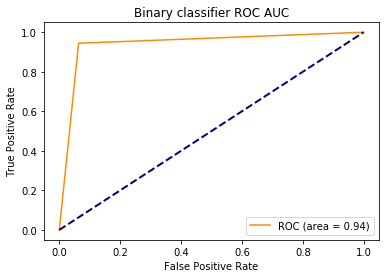

In [322]:
fpr, tpr, thresh = roc_curve(y_b_test, binary_preds)
roc_auc = auc(fpr, tpr)

plt.title('Binary classifier ROC AUC')
plt.plot(fpr, tpr, color='darkorange', label=f"ROC (area = {round(roc_auc,2)})")
plt.plot([0,1], [0,1], color='navy', lw = 2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend( loc="lower right")
plt.show()

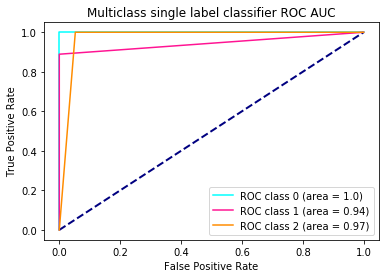

In [323]:
colors = ['aqua', 'deeppink', 'darkorange']

plt.title('Multiclass single label classifier ROC AUC')
plt.plot([0,1], [0,1], color='navy', lw = 2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i in range(3):
    fpr, tpr, _ = roc_curve(y_i_test[:, i], multiclass_preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], label=f"ROC class {i} (area = {round(roc_auc,2)})")

plt.legend( loc="lower right")
plt.show()

### Hamming Loss